In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

In [2]:
ts = pd.read_csv("data.txt", header=None, sep=',')
ts['timestamp'] = ts[0]
tmpstmp = np.array(ts.timestamp)
ts['energy_consumed'] = ts[1]
ts.drop(ts.columns[:2], axis=1,inplace=True)

In [3]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2676545 entries, 0 to 2676544
Data columns (total 2 columns):
timestamp          int64
energy_consumed    int64
dtypes: int64(2)
memory usage: 61.3 MB


In [4]:
ts['timestamp'] = pd.to_datetime(ts['timestamp'],unit='s')
ts.set_index(keys='timestamp', inplace=True)
ts = ts.tz_localize('UTC').tz_convert('US/Pacific')
ts = ts.ix[::60] #downsample dataset
ts.head(10)

,energy_consumed
timestamp,
2011-08-01 00:00:00-07:00,1322
2011-08-01 00:01:00-07:00,1322
2011-08-01 00:02:00-07:00,1284
2011-08-01 00:03:01-07:00,1308
2011-08-01 00:04:01-07:00,1294
2011-08-01 00:05:01-07:00,1300
2011-08-01 00:06:01-07:00,1286
2011-08-01 00:07:01-07:00,1282
2011-08-01 00:08:01-07:00,1270


In [5]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44610 entries, 2011-08-01 00:00:00-07:00 to 2011-08-31 23:59:55-07:00
Data columns (total 1 columns):
energy_consumed    44610 non-null int64
dtypes: int64(1)
memory usage: 697.0 KB


In [6]:
ts.index

<class 'pandas.tseries.index.DatetimeIndex'>
[2011-08-01 00:00:00-07:00, ..., 2011-08-31 23:59:55-07:00]
Length: 44610, Freq: None, Timezone: US/Pacific

# Exploratory Data Analysis

## Energy Consumption Time Series for Week 1

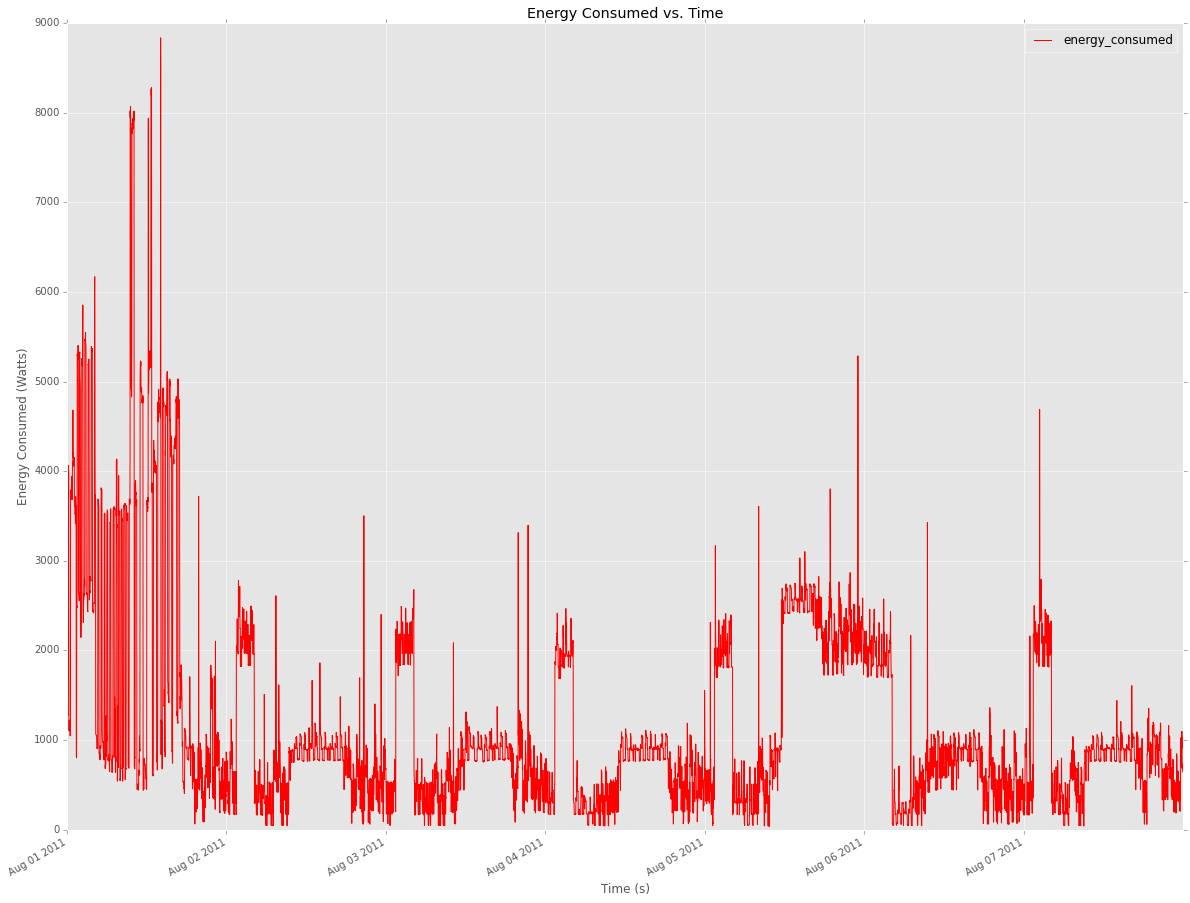

In [7]:
ts_week1 = ts[datetime(2011, 8, 1):datetime(2011,8,8)]
ts_week1.plot(figsize=(20,16), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumed (Watts)')
plt.title('Energy Consumed vs. Time')

## Energy Consumption Time Series for Week 2

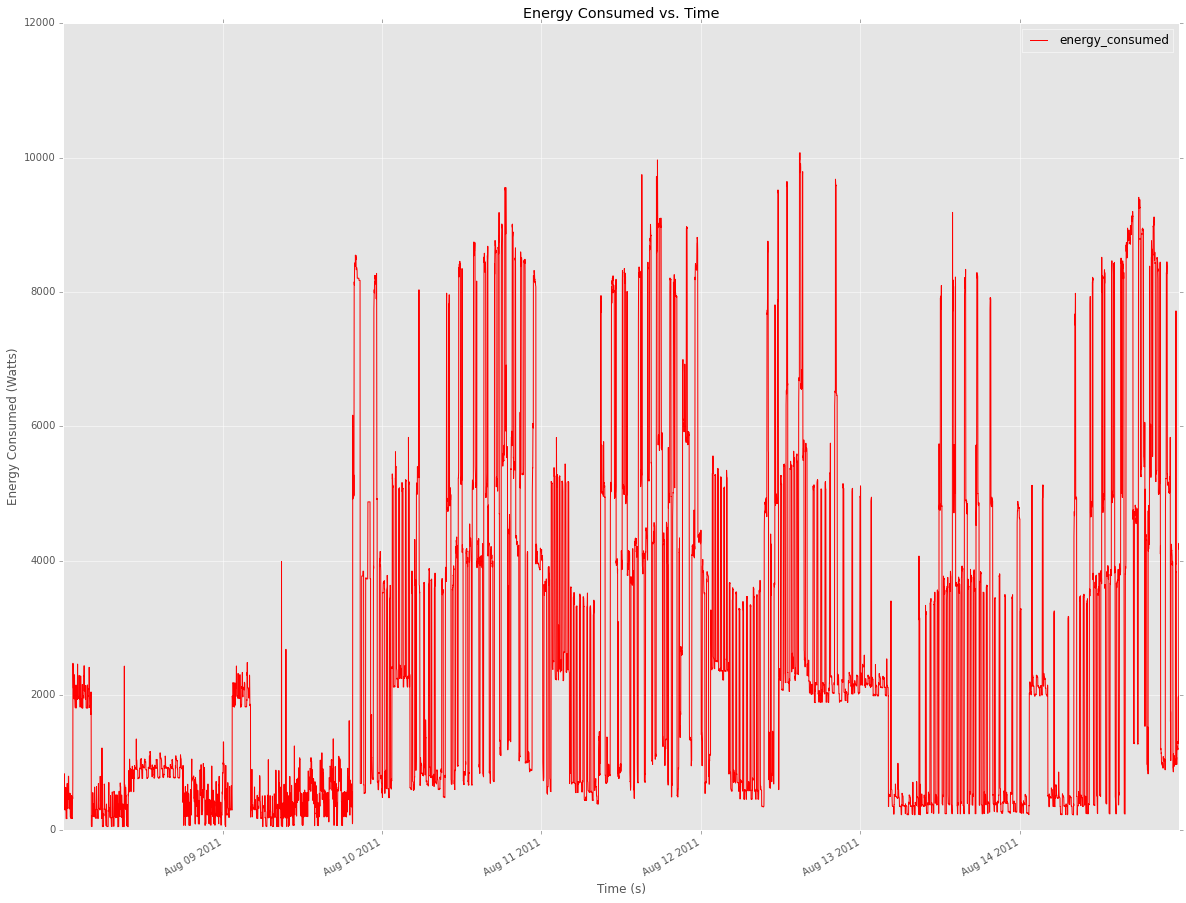

In [8]:
ts_week2 = ts[datetime(2011, 8, 8):datetime(2011,8,15)]
ts_week2.plot(figsize=(20,16), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumed (Watts)')
plt.title('Energy Consumed vs. Time')

## Energy Consumption Time Series for Day 1

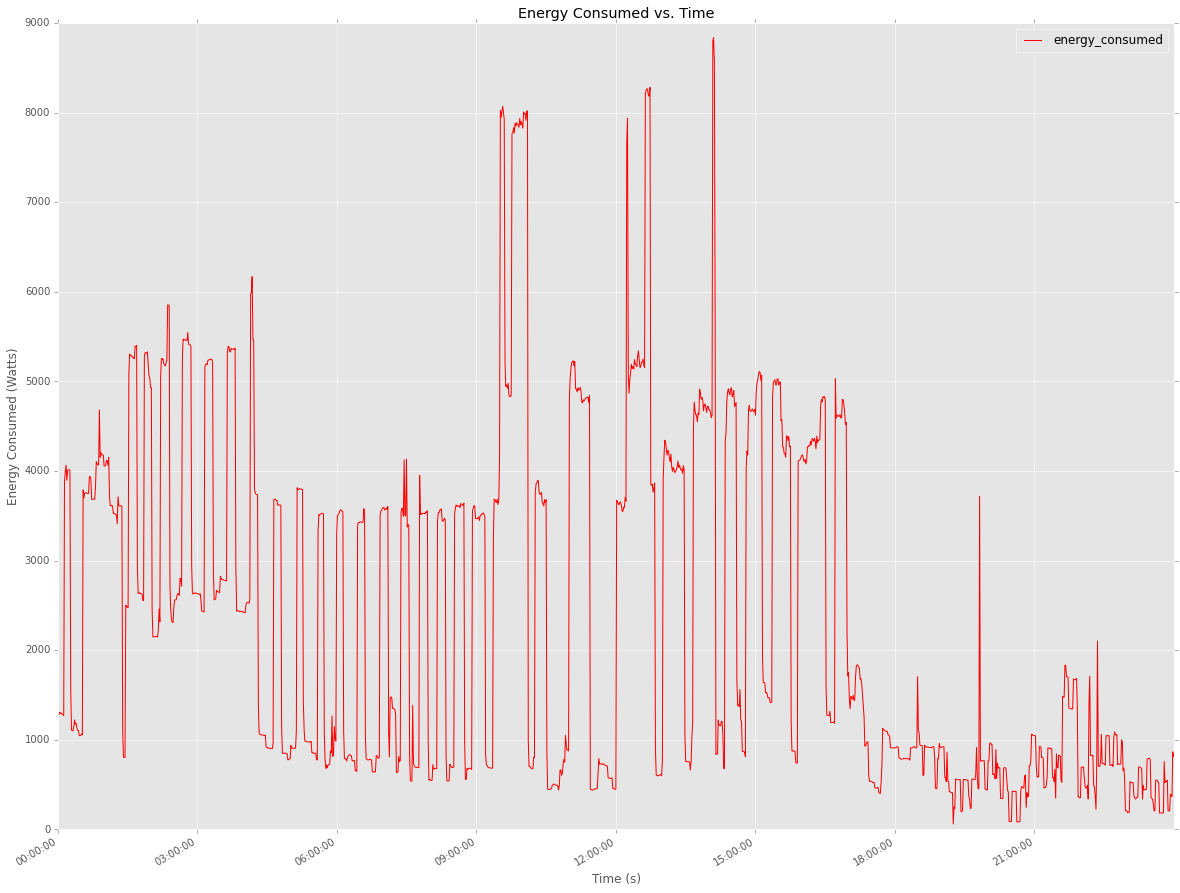

In [15]:
ts_day1 = ts[datetime(2011, 8, 1):datetime(2011,8,2)]
ts_day1.plot(figsize=(20,16), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumed (Watts)')
plt.title('Energy Consumed vs. Time')

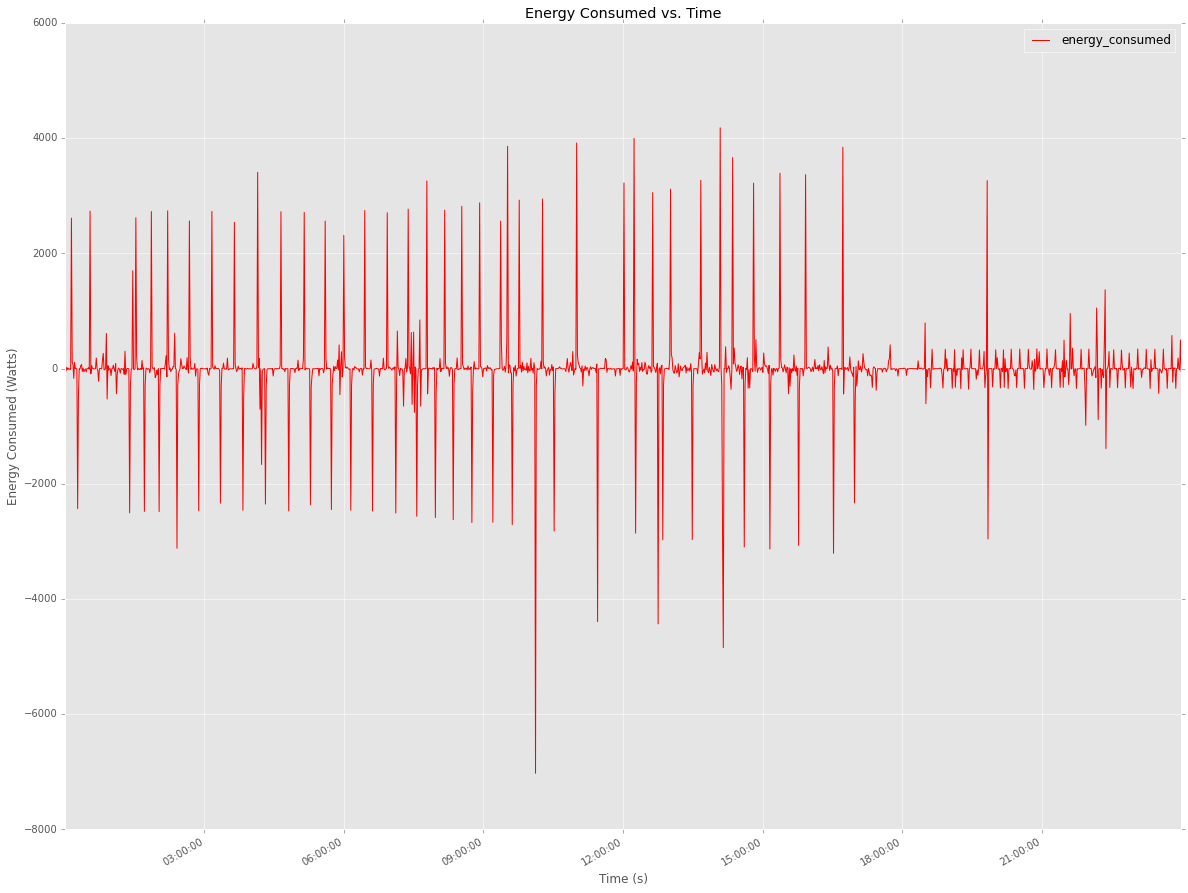

In [16]:
delta_ts_day1 = ts_day1.diff(1)[1:]
delta_ts_day1.plot(figsize=(20,16), color='r')
plt.xlabel('Time (s)')
plt.ylabel('Energy Consumed (Watts)')
plt.title('Energy Consumed vs. Time')

# Data Processing

## Time Series Segmentation: Sliding Window Subsequences

In [17]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result    
    for elem in it:
        result = result[1:] + (elem,)
        yield result

matrix = []

for ts_i in window(ts.energy_consumed, 30):
    matrix.append(ts_i)

matrix = np.array(matrix)
matrix.shape

(44581, 30)

In [18]:
dates_matrix = []

for time in window(ts.index, 30):
    dates_matrix.append(time)
    
dates_matrix = np.array(dates_matrix)
dates_matrix.shape

(44581, 30)

## Make Labels for Segmented Time Series Data According to Given Information

- Refrigerator (Label 1) - This is the smallest amplitude repeating pulse at < 200 W
- Pool Pump (Label 2) - Runs for a duration of about 3 hours at 1.5 KW amplitude. Starts at the same time everyday.
- Central AC 1 (Label 3) - The most common repeating pulse. (At about 2.5 KW amplitude and a width of about 10 minutes)
- Central AC 2 (Label 4) - Another repeating pulse but less frequent (At about 4 KW amplitude and > 30 minute width)

In [19]:
labels = []
for ts_i in matrix:
    delta_ts_i = np.diff(ts_i)
    if all(ts_i < 1000): #Refrigerator Appliance
        label = 1
    elif all((ts_i > 1750) & (ts_i < 6000)): #Pool Pump Appliance
        label = 2
    elif any((delta_ts_i <= -2500) | (delta_ts_i >= 2500)) and all(ts_i < 8000): #AC1 Appliance
        label = 3
    elif any(ts_i > 8000): #AC2 Appliance
        label = 4
    else: #Other Appliances (Unknown)
        label = 5
    labels.append(label)
labels = np.array(labels)

In [20]:
from collections import Counter
d = Counter(labels)
print d

Counter({3: 15367, 4: 11667, 2: 6296, 5: 5718, 1: 5533})


# Supervised Learning: Time Series K-Nearest Neighbor Classification

In [235]:
# from sklearn.metrics import classification_report

class ts_KnnClassifier(object):
    def __init__(self):
        '''
        preds is a list of predictions that will be made.
        plotter indicates whether to plot each nearest neighbor as it is found.
        '''
        self.preds=[]

    def predict(self, X_train, X_test, y_train, w, progress=False):
        '''
        1-nearest neighbor classification algorithm using LB_Keogh lower 
        bound as similarity measure. Option to use DTW distance instead
        but is much slower.
        '''
        for i, s1 in enumerate(X_test):
            if progress and i % 1000 == 0:
                print str(i+1) + ' points classified'
            min_dist = float('inf')
            closest_seq_ind = []

            for j, s2 in enumerate(X_train):
                if self.LB_Keogh(s1, s2, 5) < min_dist:
                    dist = self.DTWDistance(s1, s2, w)
                    if dist < min_dist:
                        min_dist = dist
                        closest_seq_ind = j
            self.preds.append(y_train[closest_seq_ind])

    def performance(self, true_results):
        '''
        If the actual test set labels are known, can determine classification
        accuracy.
        '''
        return classification_report(true_results, self.preds)

    def get_preds(self):
        return self.preds

    def DTWDistance(self, s1, s2, w=None):
        '''
        Calculates dynamic time warping Euclidean distance between two
        sequences. Option to enforce locality constraint for window w.
        '''
        DTW={}

        if w:
            w = max(w, abs(len(s1)-len(s2)))

            for i in range(-1,len(s1)):
                for j in range(-1,len(s2)):
                    DTW[(i, j)] = float('inf')

        else:
            for i in range(len(s1)):
                DTW[(i, -1)] = float('inf')
            for i in range(len(s2)):
                DTW[(-1, i)] = float('inf')

        DTW[(-1, -1)] = 0

        for i in range(len(s1)):
            if w:
                for j in range(max(0, i-w), min(len(s2), i+w)):
                    dist= (s1[i] - s2[j])**2
                    DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
            else:
                for j in range(len(s2)):
                    dist= (s1[i] - s2[j])**2
                    DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])

        return np.sqrt(DTW[len(s1)-1, len(s2)-1])

    def LB_Keogh(self,s1,s2,r):
        '''
        Calculates LB_Keough lower bound to dynamic time warping. Linear
        complexity compared to quadratic complexity of dtw.
        '''
        LB_sum=0
        for ind, i in enumerate(s1):

            lower_bound=min(s2[(ind-r if ind-r >= 0 else 0):(ind + r)])
            upper_bound=max(s2[(ind-r if ind-r >= 0 else 0):(ind + r)])

            if i > upper_bound:
                LB_sum = LB_sum + (i - upper_bound)**2
            elif i < lower_bound:
                LB_sum = LB_sum + (i - lower_bound)**2

        return np.sqrt(LB_sum)

## Time Series Cross Validation Algorithm

In [236]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_predsCV = []

def performTimeSeriesCV(X_train, y_train, number_folds):
    """
    Given X_train and y_train (the test set is excluded from the Cross Validation),
    number of folds, the ML algorithm to implement and the parameters to test,
    the function acts based on the following logic: it splits X_train and y_train in a
    number of folds equal to number_folds. Then train on one fold and tests accuracy
    on the consecutive as follows:
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    ....
    Returns mean of test accuracies.
    """
    global y_predsCV
 
    print 'Size train set: ', X_train.shape
    
    # k is the size of each fold. It is computed dividing the number of 
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print 'Size of each fold: ', k
    
    # initialize to zero the accuracies array. It is important to stress that
    # in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    f1_scores = np.zeros(number_folds-1)
    precision_scores = np.zeros(number_folds-1)
    recall_scores = np.zeros(number_folds-1)
    
 
    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print ''
        
        # the split is the percentage at which to split the folds into train
        # and test. For example when i = 2 we are taking the first 2 folds out 
        # of the total available. In this specific case we have to split the
        # two of them in half (train on the first, test on the second), 
        # so split = 1/2 = 0.5 = 50%. When i = 3 we are taking the first 3 folds 
        # out of the total available, meaning that we have to split the three of them
        # in two at split = 2/3 = 0.66 = 66% (train on the first 2 and test on the
        # following)
        split = float(i-1)/i
        
        # example with i = 4 (first 4 folds):
        #      Splitting the first       4        chunks at          3      /        4
        print 'Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) 
        
        # as we loop over the folds X and y are updated and increase in size.
        # This is the data that is going to be split and it increases in size 
        # in the loop as we account for more folds. If k = 300, with i starting from 2
        # the result is the following in the loop
        # i = 2
        # X = X_train[:(600)]
        # y = y_train[:(600)]
        #
        # i = 3
        # X = X_train[:(900)]
        # y = y_train[:(900)]
        # .... 
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print 'Size of train + test: ', X.shape # the size of the dataframe is going to be k*i
 
        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        #Classify Test Folds
        ts_knn = ts_KnnClassifier()
        print ''
        print 'KNN Classifier Is Classifying Data Points'
        ts_knn.predict(X_trainFolds, X_testFold, y_trainFolds, w = 10, progress=True)
        predictions = ts_knn.get_preds()
        y_predsCV.extend(predictions)
        
        #
        
        # i starts from 2 so the zeroth element in accuracies array is i-2. performClassification()
        #is a function which takes care of a classification problem. This is only an example and 
        #you can replace this function with whatever ML approach you need.
        f1_scores[i-2] = f1_score(y_testFold, predictions, average='weighted')
        precision_scores[i-2] =  precision_score(y_testFold, predictions, average='weighted')
        recall_scores[i-2] = recall_score(y_testFold, predictions, average='weighted')
        
        
#         # example with i = 4:
#         #      Accuracy on fold         4     :    0.85423
        print 'F1 Score on fold ' + str(i) + ': ', f1_scores[i-2]
        print 'Precision Score on fold ' + str(i) + ': ', precision_scores[i-2]
        print 'Recall Score on fold ' + str(i) + ': ', recall_scores[i-2]
    
    # the function returns the means of the precision_scores, recall scores, and f1_scores on the n-1 folds    
    return precision_scores.mean(), recall_scores.mean(), f1_scores.mean()

In [27]:
X_trainFolds, y_trainFolds, X_testFold, y_testFold = performTimeSeriesCV(matrix, labels, 10)

Size train set:  (44581, 30)
Size of each fold:  4458

Splitting the first 2 chunks at 1/2
Size of train + test:  (8916, 30)

Splitting the first 3 chunks at 2/3
Size of train + test:  (13374, 30)

Splitting the first 4 chunks at 3/4
Size of train + test:  (17832, 30)

Splitting the first 5 chunks at 4/5
Size of train + test:  (22290, 30)

Splitting the first 6 chunks at 5/6
Size of train + test:  (26748, 30)

Splitting the first 7 chunks at 6/7
Size of train + test:  (31206, 30)

Splitting the first 8 chunks at 7/8
Size of train + test:  (35664, 30)

Splitting the first 9 chunks at 8/9
Size of train + test:  (40122, 30)

Splitting the first 10 chunks at 9/10
Size of train + test:  (44580, 30)


In [28]:
ts_knn = ts_KnnClassifier()
ts_knn.predict(X_trainFolds, X_testFold, y_trainFolds, w = 10, progress=True)
y_pred = ts_knn.get_preds()

1 points classified
11 points classified
21 points classified
31 points classified
41 points classified
51 points classified
61 points classified
71 points classified
81 points classified
91 points classified
101 points classified
111 points classified
121 points classified
131 points classified
141 points classified
151 points classified
161 points classified
171 points classified
181 points classified
191 points classified
201 points classified
211 points classified
221 points classified
231 points classified
241 points classified
251 points classified
261 points classified
271 points classified
281 points classified
291 points classified
301 points classified
311 points classified
321 points classified
331 points classified
341 points classified
351 points classified
361 points classified
371 points classified
381 points classified
391 points classified
401 points classified
411 points classified
421 points classified
431 points classified
441 points classified
451 points classified

In [32]:
d1 = Counter(y_pred)
print d1

Counter({3: 2009, 4: 1790, 2: 579, 1: 51, 5: 28})


In [33]:
d2 = Counter(y_testFold)
print d2

Counter({3: 2000, 4: 1810, 2: 552, 1: 50, 5: 45})


In [36]:
print ts_knn.performance(y_testFold)

             precision    recall  f1-score   support

          1       0.98      1.00      0.99        50
          2       0.95      1.00      0.97       552
          3       0.98      0.99      0.98      2000
          4       1.00      0.99      0.99      1810
          5       0.43      0.27      0.33        45

avg / total       0.98      0.98      0.98      4457



In [39]:
number_folds = 10
k = int(np.floor(float(matrix.shape[0]) / number_folds))
split = float(2-1)/2
X1 = matrix[:(k*2)]
y1 = labels[:(k*2)]
index = int(np.floor(X1.shape[0] * split))
X_trainFolds1 = X1[:index]        
y_trainFolds1 = y1[:index]
X_testFold1 = X1[(index + 1):]
y_testFold1 = y1[(index + 1):]

In [ ]:
from joblib import Parallel, delayed
from copy_reg import pickle
from types import MethodType

def _pickle_method(method):
    func_name = method.im_func.__name__
    obj = method.im_self
    cls = method.im_class
    return _unpickle_method, (func_name, obj, cls)

def _unpickle_method(func_name, obj, cls):
    for cls in cls.mro():
        try:
            func = cls.__dict__[func_name]
        except KeyError:
            pass
        else:
            break
    return func.__get__(obj, cls)

pickle(MethodType, _pickle_method, _unpickle_method)
Parallel(n_jobs=4)(delayed(ts_knn.predict)(X_trainFolds1, testInstance, y_trainFolds1) for testInstance in X_testFold1)

### Disaggregation of Time Series into Individual Appliances

In [183]:
def generateApplianceTimeSeries(X_testFold, y_pred):
    appliances_ts = [[] for _ in range(1,6)]

    #Generate Time Series for Refrigerator Appliance
    label = 1
    refrigerator_sub = np.array(X_testFold, copy=True)
    replacement = np.ones(shape=refrigerator_sub[0].shape)* 300

    #Randomnly Sample From A Collection of Refrigerator-Only
    #Time Series Segments and assign it to the occurences where
    #Not Only A Refrigerator Is On
    for i in np.nditer(np.where(y_pred != label)[0]):
        arr = refrigerator_sub[y_pred == label]
        index_array = np.arange(arr.shape[0])
        np.random.shuffle(index_array)
        replacement = arr[index_array[0]]
        refrigerator_sub[i] = replacement

    refrigerator_ts = []
    for i in range(len(refrigerator_sub)):
        if i == 0:
            refrigerator_ts.extend(list(refrigerator_sub[i]))
        else:
            refrigerator_ts.append(refrigerator_sub[i][-1])

    appliances_ts[label - 1] = refrigerator_ts

    #Generate Time Series for Non-refrigerator Appliances
    for label in range(2,6):
        appliance_sub = np.array(X_testFold, copy=True)
        replacement = np.zeros(shape=appliance_sub[0].shape)
        appliance_sub[y_pred != label] = replacement

        appliance_ts = []
        for i in range(len(appliance_sub)):
            if i == 0:
                appliance_ts.extend(list(appliance_sub[i]))
            else:
                appliance_ts.append(appliance_sub[i][-1])
        appliances_ts[label - 1] = appliance_ts

    # for ts_i in appliances_ts:
    #     print ts_i
    
    return appliances_ts

In [184]:
appliances_ts = generateApplianceTimeSeries(X_testFold, y_pred)

In [200]:
def convertAppliancesTimeSeriesToDataFrames(appliances_ts, tmpstmp, index=-4486):
    appliances = ['Central AC1 (W)', 'Central AC2 (W)', 'Pool Pump (W)', 'Refrigerator (W)']
    labels = [2, 3, 1, 0]
    ts_dfs = []

    for idx, label in enumerate(labels):
        s = pd.DataFrame(appliances_ts[label])
        s[appliances[idx]] = s[0]
        s['timestamp'] = tmpstmp[::60][index:]
        s['timestamp'] = pd.to_datetime(s['timestamp'],unit='s')
        s.drop(0,axis=1,inplace=True)
        s.set_index(keys='timestamp', inplace=True)
        s = s.tz_localize('UTC').tz_convert('US/Pacific')
        ts_dfs.append(s)
    return ts_dfs

In [201]:
ts_dfs = convertAppliancesTimeSeriesToDataFrames(appliances_ts, tmpstmp)

### Data Visualiztion of Energy Consumption Time Series for Individual Applications

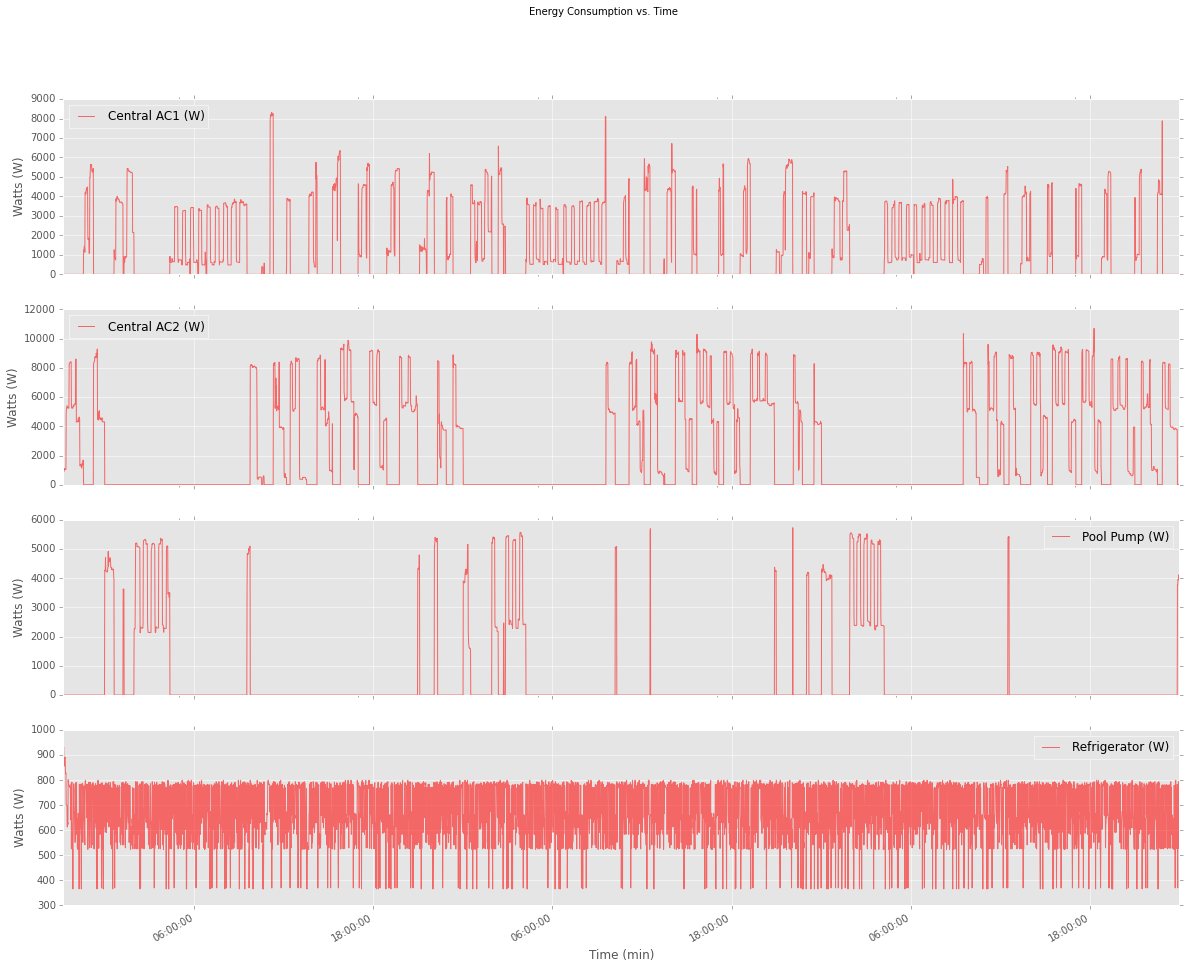

In [226]:
def plotDisAggregatedTimeSeries(ts_dfs):
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,16))
    nrow = 0
    for s in ts_dfs:
        ax=axes[nrow]
        s.plot(color='red', ax=ax, alpha=0.55)
        ax.set_ylabel('Watts (W)')
        nrow += 1
    plt.xlabel('Time (min)')
    plt.suptitle('Energy Consumption vs. Time')
    plt.savefig('Individual-Applications-Time-Series.png')

plotDisAggregatedTimeSeries(ts_dfs)

In [ ]:
precision_cv, recall_cv, f1_cv= performTimeSeriesCV(matrix, labels, 10)
print "Precision: %s, Recall: %s, F1 %s: for CV = 10" %(precision_cv, recall_cv, f1_cv)

In [221]:
print classification_report(y_testFold1, y_predsCV)

             precision    recall  f1-score   support

          1       0.88      0.97      0.92      1712
          2       0.74      0.95      0.84       872
          3       0.98      0.93      0.96        59
          5       0.93      0.72      0.81      1814

avg / total       0.87      0.86      0.86      4457

